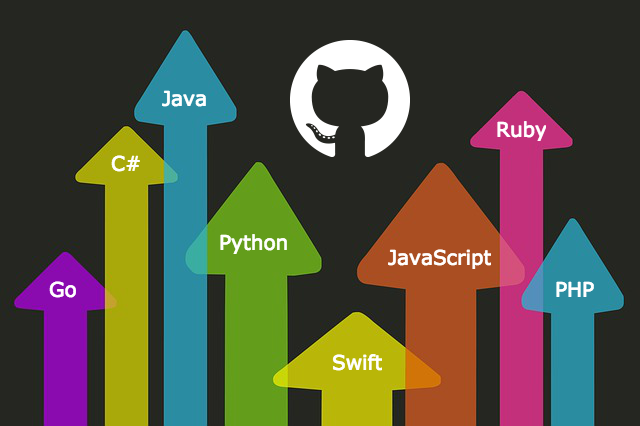

<h1><center>Natural Language Processing of Trending Github Repository READMEs </center></h1>

Corey Baughman and Caroline Miller

Codeup - Data Science

O'Neil Cohort

17 May 2023

**Project Description:** 

"Github is where over 100 million developers shape the future of software, together." 

Github provides software developers the ability to publish their own code and projects as well as explore the code of other contributors. Coding is a skill with a vast number of programming languages, libraries, and methodologies. Coding is also an art that can illustrate each developer's personal style, thought processes, and technical strengths. 

When exploring the code of other developer's to learn another tehnical skill, familiarize yourself with alternate solutions, or simply to get some inspiration, it is important to know which repositories are written in programming languages that you are working with as many are unique in functionality and syntax. 

This project aims to use Natural Language Processing tools to ultimately classify a repositories programming simply using the diction in the README. This is important because who wants to spend time opening up countless files to examine the contents and see which programming language is used. READMEs are an important aspect of any repository, and the strength of your project could be reflected in this piece of writing. If a project is useful, the README is a persuasive summary outlining the context and technical aspects of the project. 

**Project Goals:** 

This project uses several different skills and methods to include script writing, web scraping, regular expressions, data visualization, stastical hypothesis testing, feature engineering, text sparsing, and machibe learning modeling. The project creates a model which performs better than the baseline in predicting the programming language of a Github repository solely using the text data in the README. The project also finds significant insights about the text data itself.

#### Data Dictionary

| Attribute | Description of Attribute |
| :---------| :------------------------ |
| basic_clean | Original README text converted to all lowercase and characters normalized to 'NFKD' then encoded to ascii and decoded back to utf-8. Regular expression were then applied to replace all occurrences of newline characters carriage returns and match and remove any character that is not a letter (uppercase or lowercase), digit, apostrophe ('), or whitespace. |
| clean | A column with the text from basic_clean that is tokenized and has stopwords removed with nltk.tokenize.toktok.ToktokTokenizer() and nltk.corpus.stopwords(). |
| compound_ratio | The compound ratio is a single numerical value between -1 and +1 that indicates the overall sentiment polarity of a text. |
| language | The target of modeling. This is the primary coding language of repo. It is either Python, Javascript, or Rust. |
| lemmatized | A column with the lemmatized versions of the original README texts. Lemmatized with nltk.WordNetLemmatizer(). |
| num_unique | The number of unique words used in each README. |
| percent_unique | The percentage of unique words v. total words in each README. |
| repo | the url extension for the repo. It is formatted for GitHub REST API. Remove leading period and insert https://github.com/ to navigate to repo. |
| stemmed | A column with the cleaned READMEs where the words have been stemmed using nltk.porter.PorterStemmer(). |
| stopword_count | A column with a count of the total stopwords in each original README text. |
| stopword_ratio | A column with the ratio of stopwords to other words in each original README text. |
| word_count | the total number of words in each README. |

#### Imports

In [1]:
# Modules authored by the project creators
import wrangle as w
import explore as e
import acquire as a
import modeling as m
import warnings
warnings.filterwarnings("ignore")
import scipy.stats as stats

#### Acquire

The repositories used in this project share the theme of being trending repositories according to Github.

The acquisition includes the text of 164 READMEs from the Github API using the requests module and BeautifulSoup. 

For the purpose of Classification, only repositories using the following three programming languages were utilized:  Python, JavaScript, and Rust.

Used a python script to get URLs of trending repos. GitHub only makes the top 25 available but language and time window parameters can be adjusted, so the script was able to retrieve the top 25 for each of three languages and also check daily, weekly, and monthly lists. This yielding 225 trending repos evenly distributed across the three classes(languages). After removing duplicates (there was some overlap between the time windows) We were able to retrieve 164 total READMEs: Python 58, JavaScript 56, and Rust 50, on 14 May 2023.

Note: There were no null values.

#### Prepare

In [2]:
# Using the wrangle module, the webscraping functions from the acquire module
# produce the following raw dataframe.
df = w.acquire_github_data()
df.head(3)

,repo,language,readme_contents
0,./WebGoat/WebGoat,JavaScript,# WebGoat 8: A deliberately insecure Web Appli...
1,./vercel/next-react-server-components,JavaScript,# Next.js App Router + React Server Components...
2,./LaurentMazare/tch-rs,Rust,# tch-rs\nRust bindings for the C++ api of PyT...


The wrangle module uses the following steps to clean the README contents:

   1. lower()
   2. unicodedata.normalize to remove any inconsistencies in unicode character encoding
   3. .encode to convert the resulting string to the ASCII character set
   4. .decode to turn the resulting bytes object back into a string
   5. regular expressions cpture groups to isolate words and numbers
   6. tokenize to break words and any punctuation left over into discrete units
   7. lemmatize to keep only the root words
   8. remove stopwords as listed in the english dictionary (according to nltk.corpus)

The following features are engineered:

   1. count of stopwords
   2. ratio of stopwords to all words
   3. calcualtion of sentiment
   4. number of unique words
   5. ratio of unique words to all words

#### Exploratory Data Analysis

In [3]:
# Splitting the data to prevent data leakage. The exploratory data analysis is 
# conducted on the train data set.

train, validate, test = w.split_data()

In [4]:
all_freqs = e.get_word_count_frequency_df()
all_freqs.head(3)

,python,javascript,rust,all
close,563,11,8,582
intern,536,26,7,569
use,522,1053,501,2076


**1. What are the most frequently used words across the three programming languages and are any of them shared between them?**

The most frequently used words per language

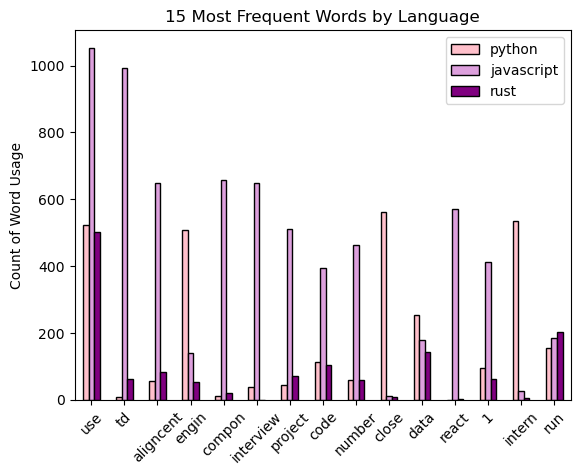

In [5]:
e.viz_top_word_freqs()

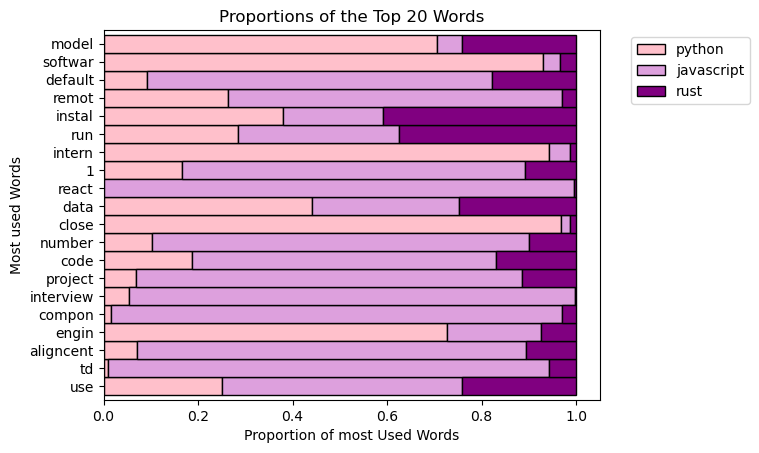

In [6]:
e.viz_proportional_word_freq()

**Finding:** Most of top used words proportionally are not evenly distributed amongst the three languages; most are unique to one particular language. We predict this be reflected in the model's abilty to differentiate between languages. 

**Note:** The <td> HTML element defines a cell of a table that contains data. 'aligncenter' is also unique to JavaScript; a developer can aligntext into the center by manipulating the CSS properties.

**Shared Words include 'use', 'run, 'install', and data'**

**Note:** Top words in JavaScript READMEs pertain to design in HTML and CSS, which are not shared by Python nor Rust.

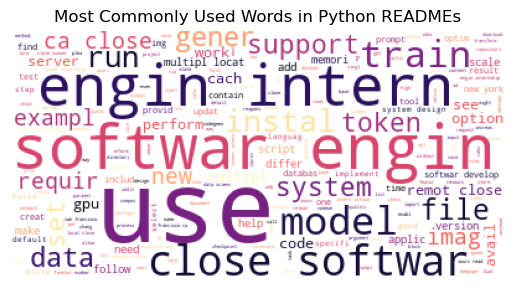

In [7]:
e.viz_python_word_cloud()

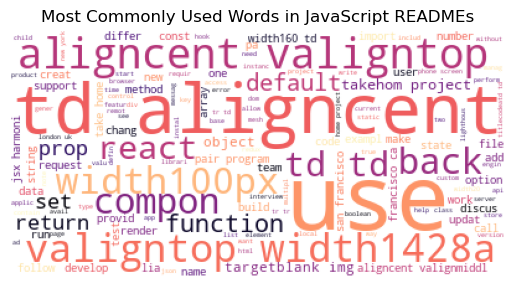

In [8]:
e.viz_java_word_cloud()

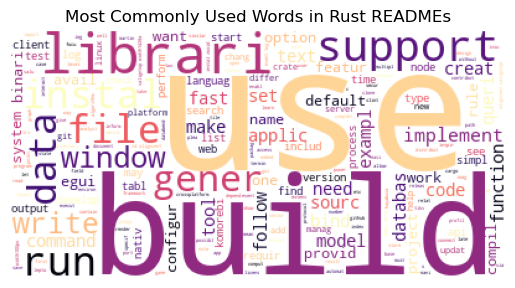

In [9]:
e.viz_rust_word_cloud()

In [10]:
# Dividing each language into a dataframe

python, java, rust = e.train_by_language()

**2. Are the means of the sentiment values for each language different?**

H$_O$: The average sentiment values between Python, JavaScript, and Rust READMEs are NOT different .

H$_A$: The average sentiment values between Python, JavaScript, and Rust READMEs are different.

Note:  The variance is not equal, therefore the Alexander Govern test is utilized.

In [11]:
# Conducting Alexander Govern statistical test for more than two samples where
# the variance is not equal
α = 0.05

print(stats.alexandergovern(python.compound_sentiment, java.compound_sentiment, rust.compound_sentiment))
print(f'We fail to reject the null hypothesis, which means that the means are different')

AlexanderGovernResult(statistic=4.7223688085241164, pvalue=0.09430845768236518)
We fail to reject the null hypothesis, which means that the means are different


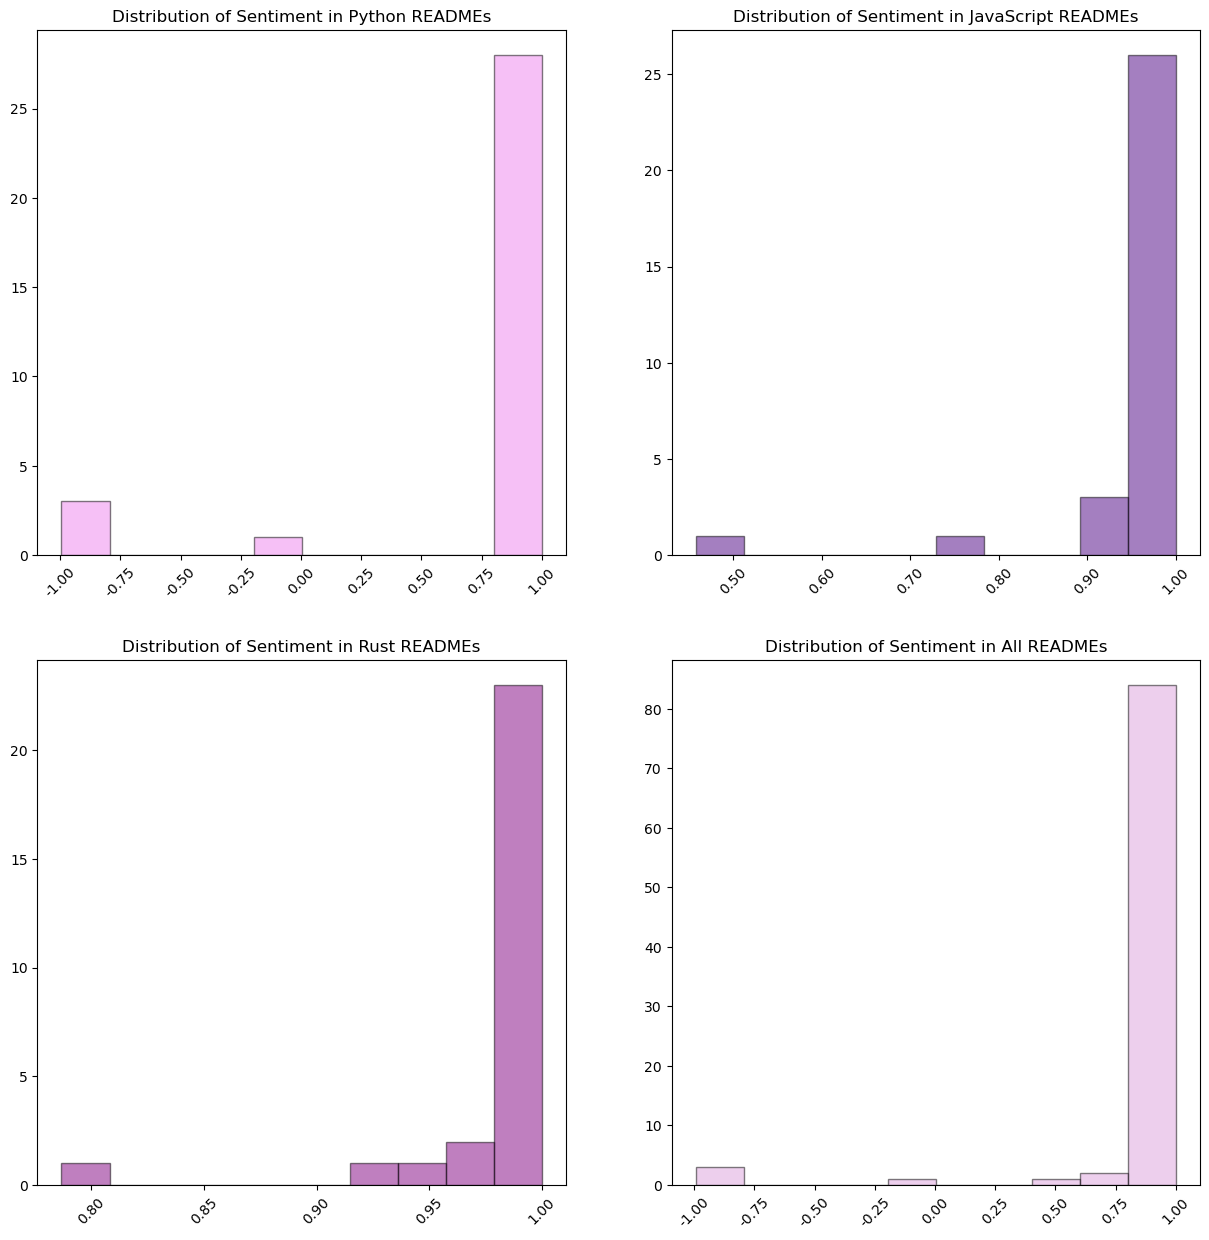

In [12]:
# Visualization of the Distribution of Sentiment Values

e.viz_sentiment_dis(train)

**Finding:** The means of sentiment scores between the three programming languages are different. The Python mean is significantly lower due the -1 scores which is unique to Python READMEs.

**3. Are the means of stopword ratios different between Python, JavaScript, and Rust READMEs?**

H$_O$: The average stopword percentages between Python, JavaScript, and Rust READMEs are NOT different .

H$_A$: The average stopword percentages between Python, JavaScript, and Rust READMEs are different.

Note: The variance is not equal, therefore the Alexander Govern test is utilized.

In [19]:
# Conducting Alexander Govern statistical test for more than two samples where
# the variance is not equal
α = 0.05

print(stats.alexandergovern(python.stopword_ratio, java.stopword_ratio, rust.stopword_ratio))
print(f'We fail to reject the null hypothesis, which means that the means are different')

AlexanderGovernResult(statistic=2.951858628820929, pvalue=0.22856621843632194)
We fail to reject the null hypothesis, which means that the means are different


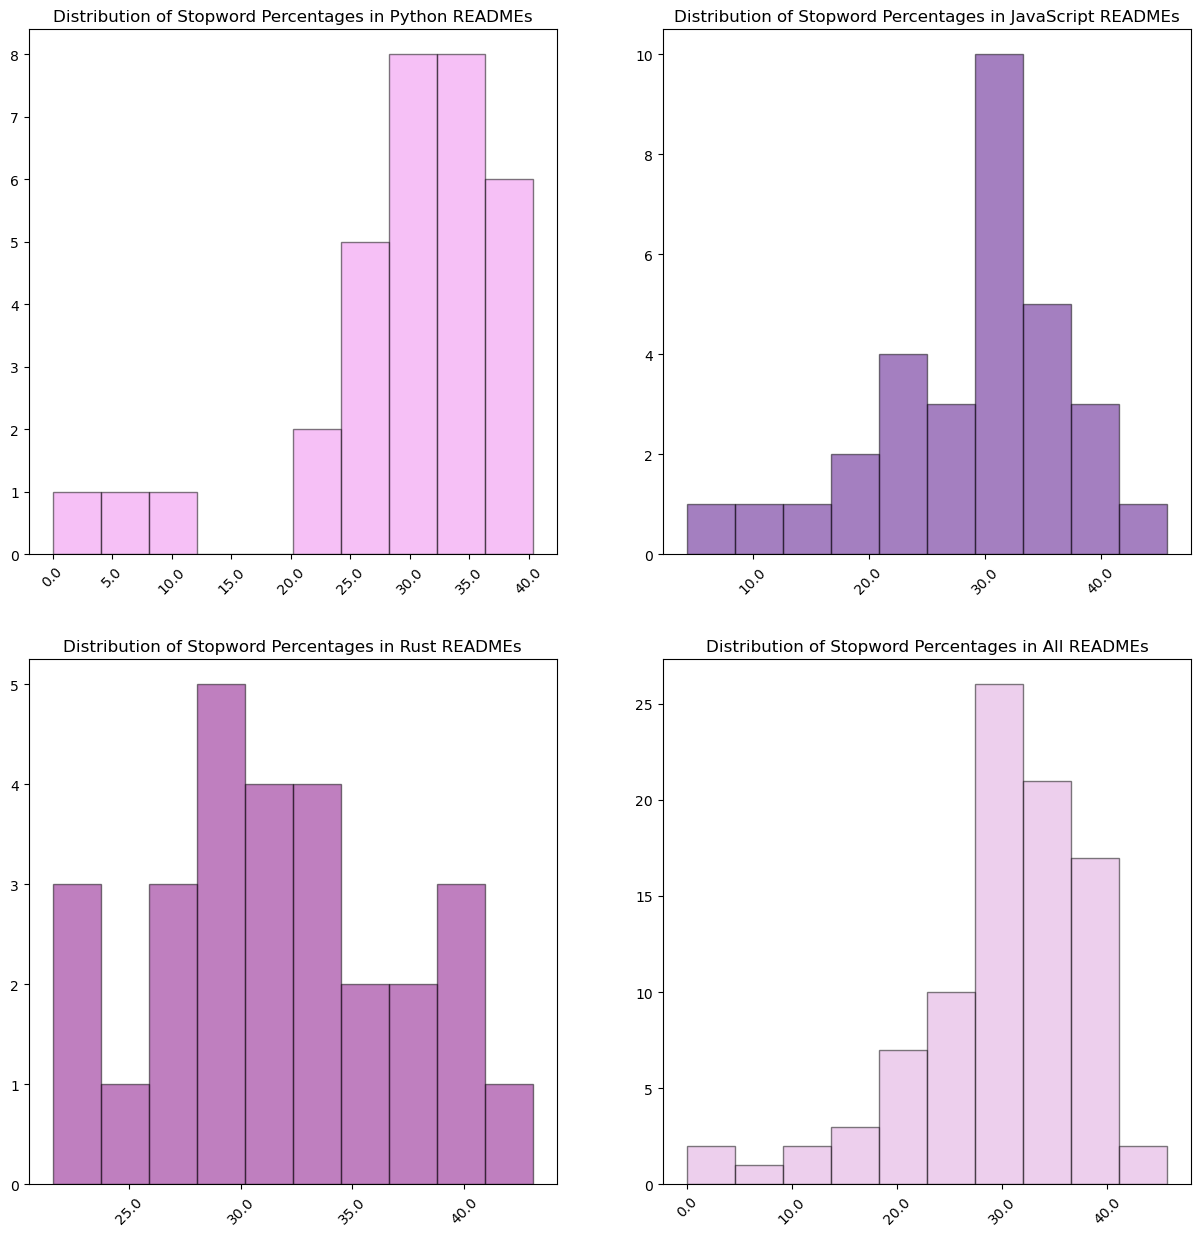

In [13]:
# Visualization of the Distribution of Stopword Ratios

e.viz_stopword_ratios(train)

**Finding:** The means of the stopword ratios between the three lprogramming languages are different. While both the Python and Javascript READMEs are skewed to the left, the Rust READMEs are relatively uniform in their content of stopwords to all words.

**4. Are the means of the unique word percentages between Python, JavaScript, and Rust READMEs different?**

H$_O$: The average unique word percentages between Python, JavaScript, and Rust READMEs have equal variance.

H$_A$: The average unique word percentages between Python, JavaScript, and Rust READMEs do NOT have equal variance.

Note: The variance is not equal, therefore the Alexander Govern test is utilized.

In [20]:
# Conducting Alexander Govern statistical test for more than two samples where
# the variance is not equal
α = 0.05

print(stats.alexandergovern(python.percent_unique, java.percent_unique, rust.percent_unique))
print(f'We fail to reject the null hypothesis, which means that the means are different')

AlexanderGovernResult(statistic=0.930466906734206, pvalue=0.6279884820498374)
We fail to reject the null hypothesis, which means that the means are different


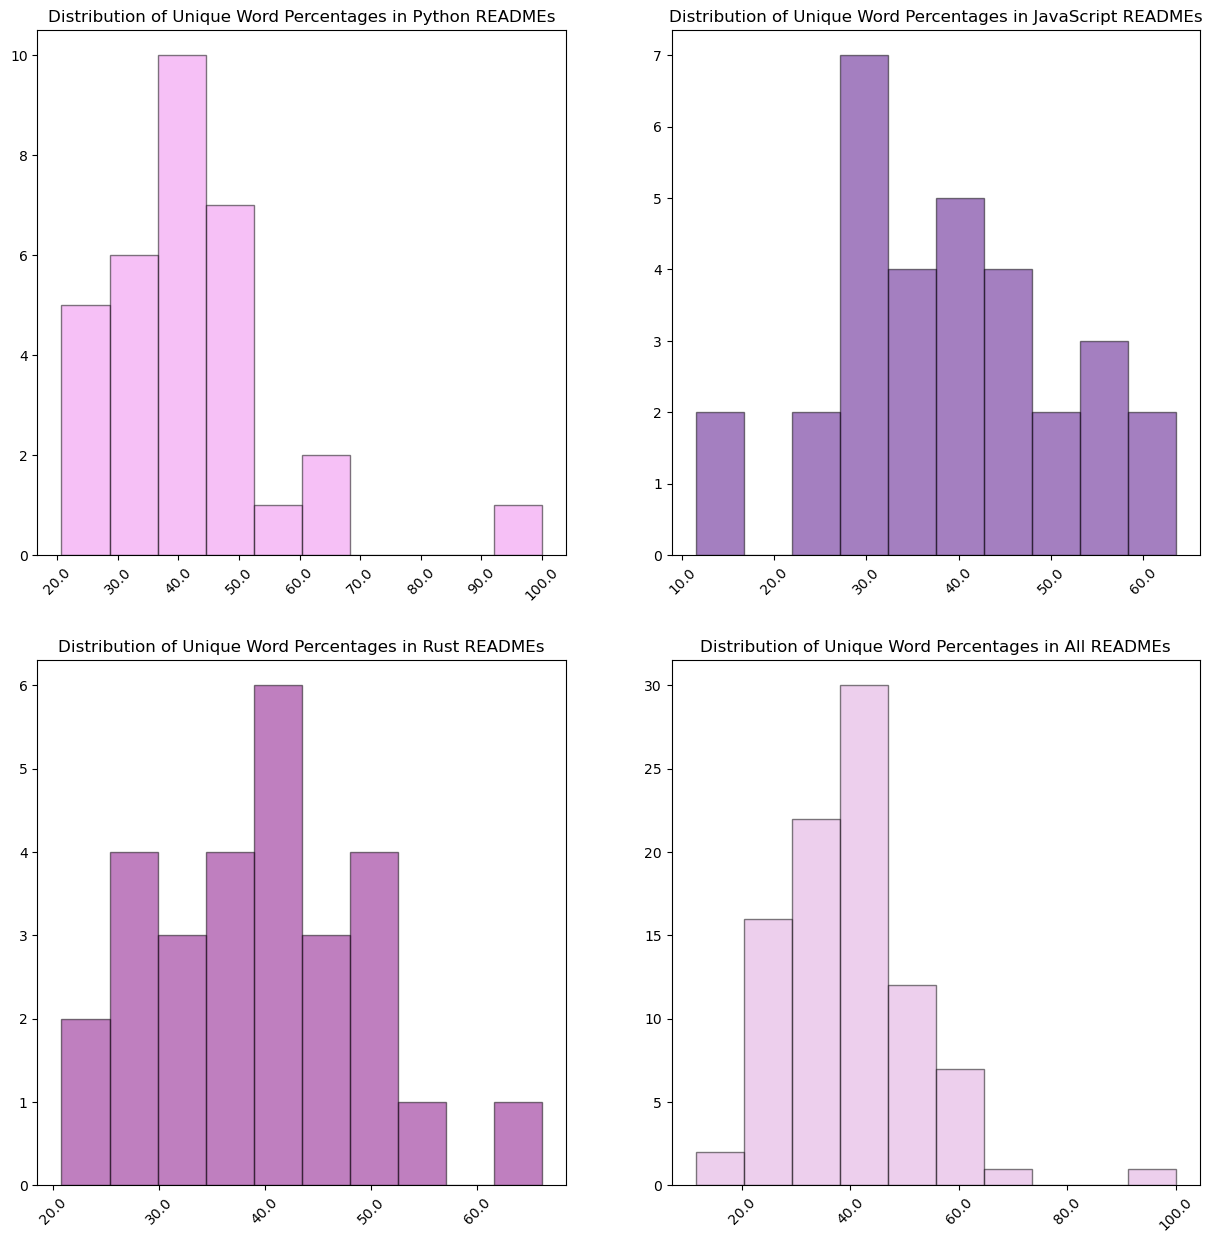

In [14]:
# Visualiation of the Distributions of Unique Word Counts

e.viz_unique_ratios(train)

**Finding:** The means of unique word counts between the three programming languages are different.The overall distribution is skewed to the right, though it seems that Python READMEs are the only ones which strongly mirror this trend; the Javascript and essentially the Rust READMEs are realtively more uniformly distributed. This indicates that the Python concentration of unique words on thw lower side influence the total distribution greatly.

**Takeaways from Explore:** While the averages on the surface may look similar, through statistical testing, we can conclude that the means of these features are infact different. This may indicate that there are outliers which can be possibly seen in the visualizations which influence the means greatly. The theme shared amongst these visualizations is that the Rust READMEs have reltively uniform distribution in stopword usage and unique word counts, while those of JavaScript and Python tend to have a more normal distribution. Sentiment in Python READMEs is far lower than those of JavaScript and Rust, and the sentiment of Python READMEs has a greater range, being the only language with negative scores.

#### Modeling

**Goal:** To use *classification* algorithms to build a model that accurately predicts the primary coding language based on vectorized README text and features engineered from that text.

**Success Metric:** 

- Accuracy is the chosen success metric for our models: (Total Correct Predictions/ Total Predictions)
- Accuracy is a good metric since the cost/benefit of false positive predictions and false negative predictions are the same.
- The classes are approximately balanced.

**Methodology:**
- We evaluate model accuracy at predicting the correct class v all predictions.
- The model with the best balance of highest accuracy score and least dropoff in accuracy on the validation set will be selected.
- The selected model will then be assessed for production against the test dataset.

**Algorithms:**
- Decision Tree Classifier
- Random Forest Classifier
- K-Nearest Neighbors
- Naive Bayes

**Features:** the elements the model will use to make predictions
    
- Total Frequency/Inverse Document Frequency(TF/IDF) vectorized words.


**Baseline Model:**

- While the classes are almost evenly balanced, 'Python' has the most observations at 58 and will be used as the prediction for the baseline model.

 **Algorithm 1: Random Forest Classifier:**

##### I want to test the random forest classifier for a range of hyperparameters:
- bootstrap = True or False
- min_samples_leaf = range from 1-9
- max_depth = range from 1-9


**Algorithm 2: Decision Tree Classifier:**

##### I want to test the decision tree classifier for a range of hyperparameters:
- min_samples_leaf = range from 1-9
- max_depth = range from 1-9


**Algorithm 3: K-Nearest Neighbors(KNN) Classifier:**

##### I want to test the KNN classifier for a range of hyperparameters:
- n_neighbors = range from 2 - 20 step of 2


**Algorithm 4: Multinomial Naive Bayes Classifier:**

##### I want to test the Multinomial Naive Bayes classifier for a range of hyperparameters:
- alpha = range from 0.1 to 5.0


**Model Results:**

- **Baseline Model Results:**

In [15]:
m.baseline_models(train, validate, test)

,baseline_accuracy
train,0.351648
validate,0.350000
test,0.363636


***

- **Text Only Models:** Results of models for all described hyperparameters run on TF/IDF vectorized corpus of READMEs with no additional features

In [16]:
m.model_data(train, validate, 'language')

,hyperparams,accuracy_train,accuracy_val,algorithm
0,"(False, 2, 8)",0.989011,0.750,random_forest
1,"(7, 10)",0.879121,0.675,decision_tree
2,16,0.791209,0.850,knn
3,default,1.000000,0.800,multinomial_naive_bayes


- **results:** the knn model with n=16 was the best performing model of the text only models with a .85 accuracy on validate, up from .79 on train.

***

- **Text Plus Features Models:** 'word_count', 'stopword_ratio', 'compound_sentiment', 'percent_unique' added in addition to vectorized words and all features were scaled with MinMaxScaler

In [17]:
m.model_data_plus(train, validate, 'language')

,hyperparams,accuracy_train,accuracy_val,algorithm
0,"(True, 1, 7)",1.000000,0.750,random_forest
1,"(7, 10)",0.879121,0.675,decision_tree
2,20,0.593407,0.475,knn
3,default,0.329670,0.400,multinomial_naive_bayes


- **results:** all models with features added performed worse than those run on just the vectorized words.

***

- **Best Model Performance on Test Dataset:** we tested the text-only, knn model with k=16 on the out-of-sample data:

In [18]:
m.best_model_on_test(train, validate, test, 'language')

,hyperparams,accuracy_train,accuracy_validate,accuracy_test,algorithm
0,16,0.791209,0.85,0.606061,knn


**Finding:** For our best model, there was significant drop-off between our test dataset and our train and validation set. The final accuracy was 0.606 which beat the baseline of 0.364 by 66.5%.

**Takeaways from Modeling:** We were able to accomplish our goal of creating a model that beat baseline at predicting the primary coding language of repositories. However, we also found that we had a significant drop off in our model performance 'in the wild'. Some possible reasons for this may be the relatively small size of our dataset leading to some lengthly READMEs skewing the word distributions. Increasing the size of the dataset is possible by running the webscraping script over time to increase the pool of results.

#### Conclusion 

**Findings:** 
    
    Engineered features useful for exploratory data analysis, but not for modeling

    Top words of each language are not shared  

    KNN best for modeling

**Next Steps:** 

    Acquire more READMEs

    Use Clusters as features

    Refine regular expressions

    Use CountVectorization instead of TF/IDF to see if the results are better

    Look into incorporating Latent Dirichlet Allocation (LDA)

**Recommendations:**

    Use repositories using only one programming language

    Clean the documents 

    Include programming languages when removing stopwords 

    Avoid a surplus of programming languages 